<div align="right" style="text-align:right"><a href="http://norvig.com">Peter Norvig</a><br>March 2019</div>

#  Dice Baseball Simulation

The [538 Riddler for March 22, 2019](https://fivethirtyeight.com/features/can-you-turn-americas-pastime-into-a-game-of-yahtzee/) asks us to simulate baseball using probabilities from a 19th century dice game called *Our National Ball Game*. The Riddler description of the rules said "*you can assume some standard baseball things*" but left some things unspecified, so I [looked up](http://baseballgames.dreamhosters.com/BbDiceHome.htm) the original rules of *Our National Ball Game*, which, it turns out, contradict some of the "*standard baseball things*" assumed by 538:


|RULES FOR PLAYING "OUR NATIONAL BALL GAME"|DICE ROLL OUTCOMES|
|-----|-----|
| ![](http://baseballgames.dreamhosters.com/bbOurNationalBallGameMcGillDelanyHoag86diE2.jpg) |  ![](http://baseballgames.dreamhosters.com/bbOurNationalBallGameMcGillDelanyHoag86ddE.jpg) |

# Design Choices


- To clarify: the dice roll `1,1` has probability 1/36, whereas `1,2` has probability 2/36, because it also represents `2,1`.
- Exactly one thing happens to each batter. I'll call that an **event**.
- The "One Strike" dice roll is not an event; it is only *part* of an event. From the probability of a "One Strike" dice roll, 7/36, I compute the probability of three strikes in a row, `(7/36)**3 == 0.00735`, and call that a strikeout event. 
- I'll represent events with the following 11 one letter **event codes**:
  - `1`, `2`, `3`, `4`: one-, two-, three-, and four-base (home run) hits. Runners advance same number of bases.
  - `B`: base on balls. Runners advance only if forced.
  - `D`: double play. Batter and runner nearest home are out (according to rules); others advance one base.
  - `E`: error. Batter reaches first and all runners advance one base.
  - `F`, `K`, `f`: fly out, strikeout, foul out. Batter is out, runners do not advance.
  - `S`: called "out at first" in rules, but actually a sacrifice. Batter is out, runners advance one base.

In [1]:
event_names = {
    '1': 'single',        '2': 'double',      '3': 'triple',    '4': 'home run',
    'B': 'base on balls', 'D': 'double play', 'E': 'error',
    'f': 'foul out',      'F': 'fly out',     'K': 'strikeout', 'S': 'out at first'}

#  Implementation

I'll define the function `inning` to simulate a half inning and return the number of runs scored.  Design choices for `inning`:

- I'll keep track of runners with a set of occupied bases; `runners = {1, 3}` means runners on first and third.
- I'll keep track of the number of `runs` and `outs`, and return`runs` when there are three `outs`.
- Each event follows four steps. E.g., if `runners = {1, 3}` and the `event = 2` (a double), then:
  1. The batter steps up to the plate. The plate is represented as base `0`, so now `runners = {0, 1, 3}`.
  2. Check if the event causes runner(s) to be out, and if the inning is over. In this case, no.
  3. Advance each runner according to `advance(r, e)`. In this case, `runners = {2, 3, 5}`.
  4. Remove the runners who have `scored` and increment `runs` accordingly. In this case, runner `5` has scored, so we increment `runs` by 1 and end up with `runners = {2, 3}`.
- I want `inning` to be easily **testable**: I want to say `assert 2 == inning('1Kf4F')`.
- I also want `inning` to be capable of simulating many independent random innings.  So the interface is to accept an *iterable* of event codes. That could be a string, or it could be a generator as provided by `event_stream()`.
- I want `inning` to be **loggable**: `inning(events, verbose=True)` should log each event.
- `advance(r, e)` says that a runner advances `e` bases on an `e` base hit; one base on an error, sacrifice, or double play (for the runners who are not out); and one base on a base on balls only if forced.
- A runner on base `r` is `forced` if all the lower-numbered bases have runners.
- `ONBG` is defined as a generator of random events with the probabilities from "**O**ur **N**ational **B**all **G**ame".

In [2]:
import matplotlib.pyplot as plt
import random
from statistics  import mean, stdev
from collections import Counter
from typing import List

In [42]:
def inning(events, verbose=True) -> int:
    """Simulate a half inning based on events, and return number of runs scored."""
    outs = runs = 0     # Inning starts with no outs and no runs,
    runners = set()     # and with nobody on base
    def out(r) -> int: runners.remove(r); return 1
    def forced(r) -> bool: return all(b in runners for b in range(r))
    def advance(r, e) -> int: 
        return int(e if e in '1234' else (e in 'ESD' or (e == 'B' and forced(r))))
    for e in events:
        if verbose: log(outs, runs, runners, e)
        runners.add(batter)           # Batter steps up to the plate
        if e in 'DSKfF':              
            outs += out(batter)       # Batter is out
            if e == 'D' and runners and outs < 3: 
                outs += out(max(runners)) # Double play: lead runner out
        if outs == 3:                 # If inning is over: return runs scored
            return runs 
        runners = {r + advance(r, e) for r in runners} # Runners advance
        scored  = {r for r in runners if r >= 4}       # Calculate the runners who scored
        runners = runners - scored                     # Remove runners who scored
        runs   += len(scored)                          # Tally runs
        
def event_stream(events, strike_ratio=0):
    """A generator of random baseball events."""
    while True:
        yield 'K' if (random.random() < strike_ratio ** 3) else random.choice(events)

def log(outs, runs, runners, event):
    """Print a representation of the current state of play."""
    bases = ''.join('₃²₁'[-b] if b in runners else '.∙.'[-b] for b in (3, 2, 1))
    print(f'{outs} outs {runs} runs  {bases} : {event} ({event_names[event]})')
    
ONBG   = event_stream('2111111EEBBffSSSSSSSFFFFFD334', strike_ratio=7/36) # Our National Ball Game
batter = 0 # The batter is a runner who is not yet at first base

# Examples and Tests

Let's peek at some random innings:

In [43]:
inning(ONBG) 

0 outs 0 runs  .∙. : S (out at first)
1 outs 0 runs  .∙. : S (out at first)
2 outs 0 runs  .∙. : F (fly out)


0

In [38]:
inning(ONBG)

0 outs 0 runs  .∙.  S (out at first)
1 outs 0 runs  .∙.  E (error)
1 outs 0 runs  .∙₁  3 (triple)
1 outs 1 runs  ₃∙.  2 (double)
1 outs 2 runs  .².  F (fly out)
2 outs 2 runs  .².  B (base on balls)
2 outs 2 runs  .²₁  S (out at first)


2

Let's also test some historic innings. I'll take some of the Red Sox innings from their 2004 playoff series against the Yankees.

In [39]:
# 7th inning in game 1: 5 runs (Home run by Varitek)
# (But not a perfect reproduction, because our simulation doesn't have passed balls.)
assert 5 == inning('K2f1214K')

0 outs 0 runs  .∙.  K (strikeout)
1 outs 0 runs  .∙.  2 (double)
1 outs 0 runs  .².  f (foul out)
2 outs 0 runs  .².  1 (single)
2 outs 0 runs  ₃∙₁  2 (double)
2 outs 1 runs  ₃².  1 (single)
2 outs 2 runs  ₃∙₁  4 (home run)
2 outs 5 runs  .∙.  K (strikeout)


In [40]:
# 4th inning in game 6: 4 runs (Homer by Bellhorn)
assert 4 == inning('SS2114F')

0 outs 0 runs  .∙.  S (out at first)
1 outs 0 runs  .∙.  S (out at first)
2 outs 0 runs  .∙.  2 (double)
2 outs 0 runs  .².  1 (single)
2 outs 0 runs  ₃∙₁  1 (single)
2 outs 1 runs  .²₁  4 (home run)
2 outs 4 runs  .∙.  F (fly out)


In [41]:
# 2nd inning in game 7: 4 runs (Grand Slam by Damon)
assert 4 == inning('S1BB4BFS')

0 outs 0 runs  .∙.  S (out at first)
1 outs 0 runs  .∙.  1 (single)
1 outs 0 runs  .∙₁  B (base on balls)
1 outs 0 runs  .²₁  B (base on balls)
1 outs 0 runs  ₃²₁  4 (home run)
1 outs 4 runs  .∙.  B (base on balls)
1 outs 4 runs  .∙₁  F (fly out)
2 outs 4 runs  .∙₁  S (out at first)


That looks good to me.

# Monte Carlo Simulation

Now, simulate a hundred thousand innings, and then sample from them to simulate a hundred thousand nine-inning games (for one team), and show histograms of the results, labelled with statistics:

In [44]:
def simulate(N: int, inning=inning, events=ONBG) -> None:
    innings = [inning(events=events, verbose=False) for _ in range(N)]
    games   = [sum(random.sample(innings, 9)) for _ in range(N)]
    hist(innings, N, 'Runs per inning (for one team)')
    hist(games,   N, 'Runs per game (for one team)')
    
def hist(nums, N, title): 
    """Plot a histogram and show some statistics."""
    bins = range(min(nums), max(nums) + 2)
    plt.hist(nums, ec='black', bins=bins, align='left')
    if len(bins) <= 20: plt.xticks(bins[:-1])
    plt.xlabel(f'''{title}\nmean: {mean(nums):.2f}, max: {max(nums)}, σ: {stdev(nums):.2f}, N: {N:,d}''')
    plt.show()

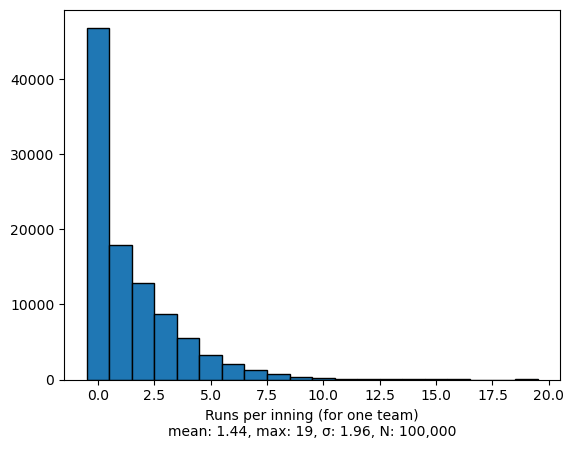

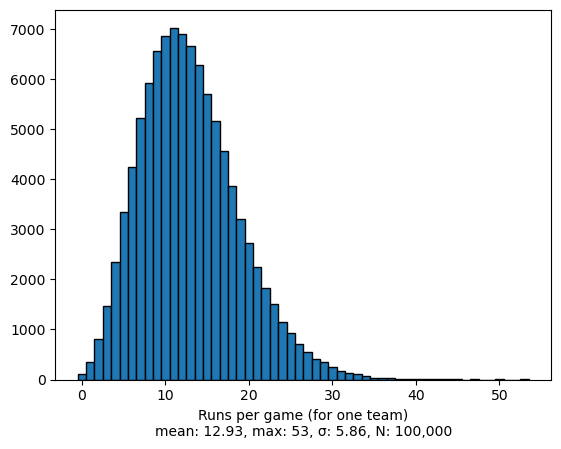

In [45]:
simulate(N=100000)

So, about 13 runs per game (per team). This shows that the dice game is not very realistic with respect to current-day baseball. It is true that games were higher-scoring 130 years ago. Also,  a dice game is more fun when there is a lot of action.

# Real Major League Baseball Stats

Could I make the game reflect baseball as it is played today? To do so I would need:
1. A source of major league baseball (MLB) statistics.
2. A way to convert those statistics into the format expected by `event_stream` and `inning`.
3. Possibly some modifications to  `inning`, depending on how the conversion goes.

[Baseball-reference.com](https://www.baseball-reference.com) has lots of stats, in particular 
[MLB annual batting stats](https://www.baseball-reference.com/leagues/MLB/bat.shtml) and
[fielding stats](https://www.baseball-reference.com/leagues/MLB/field.shtml); I'll use the stats for the complete 2019 season. The batting stats have most of what we need, and the fielding stats show double plays and errors.

I start by defining two utility functions that can be useful for any tabular data: `cell_value`, which converts a table cell entry into an `int`, `float`, or `str` as appropriate; and `header_row_dict`, which creates a dict of `{column_name: value}` entries. The function `mlb_convert` then converts this format (a dict keyed by `H/2B/3B/HR` etc.) into the event code format (a string of `'1234...'`). As part of the conversion  I'll add hit-by-pitch (`HBP`) into the "base on balls" category, and I'll record all otherwise  unaccounted-for outs under the "fly out" (`F`) category (runners do not advance). With this understood, we won't need to change the function `inning` at all. (It is true that `mlb_convert` returns a very long string, equal in length to the number of plate appearances over the whole MLB season. But that takes up less space than storing one photo, so I'm not going to worry about it.)

In [47]:
round(123.0, 3)

123.0

In [49]:
def number(entry: str) -> float:
    """Convert a string to a number."""
    return float(entry) if '.' in entry else int(entry)
    
def header_row_dict(header, row, sep=None) -> dict:
    """Parse a header and table row into a `{column_name: number,...}` dict."""
    return dict(zip(header.split(sep), map(number, row.split(sep))))

def mlb_convert(stats: dict) -> Counter:
    """Given baseball stats with MLB names, return a Counter with ONBG names."""
    events = Counter({
        '1': stats['H'] - stats['2B'] - stats['3B'] - stats['HR'],
        '2': stats['2B'], '3': stats['3B'], '4': stats['HR'],
        'E': stats['E'],  'B': stats['BB'] + stats['HBP'],
        'K': stats['SO'], 'D': stats['DP'], 'S': stats['SH'] + stats['SF']})
    events['F'] = stats['PA'] - sum(events.values()) # All unaccounted-for outs
    return events

Below I copy-and-paste the data from baseball-reference.com to create the dict `mlb_stats`, convert it to our format with `mlb_convert`, and make one big string of events t create the event generator `mlb_stream`:

In [51]:
mlb_stats = mlb_convert(header_row_dict(
    "Year Tms #Bat BatAge R/G G PA AB R H 2B 3B HR RBI SB CS BB SO BA OBP SLG OPS TB GDP HBP SH SF IBB E DP",
    """2019 30 1284 27.9 4.84 4828 185377 165622 23346 41794 8485 783 6735 22358 2261 827 15806 42546 
    .252 .323 .435 .758 72050 3441 1968 774 1146 752 2882 3981"""))

mlb_stream = event_stream(''.join(mlb_stats.elements()))

We can take a look at the stats, and use them to play innings and games:

In [52]:
mlb_stats

Counter({'1': 25791,
         '2': 8485,
         '3': 783,
         '4': 6735,
         'E': 2882,
         'B': 17774,
         'K': 42546,
         'D': 3981,
         'S': 1920,
         'F': 74480})

In [54]:
inning(mlb_stream)

0 outs 0 runs  .∙. : F (fly out)
1 outs 0 runs  .∙. : 4 (home run)
1 outs 1 runs  .∙. : D (double play)
2 outs 1 runs  .∙. : F (fly out)


1

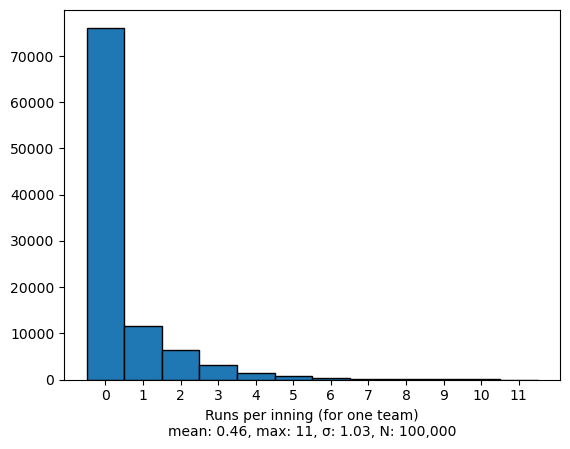

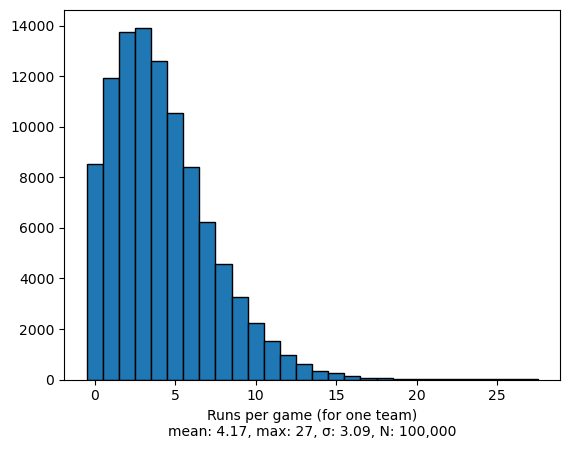

In [16]:
simulate(events=mlb_stream)

That looks a *lot* more like real baseball. But MLB averaged 4.84 runs per team per game in 2019, and this is over half a run lower. I think we can make some minor changes to the function `inning`&mdash;some "*standard baseball things*"&mdash;to make the simulation more realistic. I'm thinking of two changes:
- The most common double play eliminates the batter and the runner on first, not the runner closest to home. 
- On a single, a runner on second often scores. 

I'll make those two things the case for all double plays and singles.

In [17]:
def inning2(events, verbose=False) -> int:
    """Simulate a half inning based on events, and return number of runs scored."""
    outs = runs = 0     # Inning starts with no outs and no runs,
    runners = set()     # and with nobody on base
    def out(r) -> int: runners.remove(r); return 1
    def forced(r) -> bool: return all(b in runners for b in range(r))
    def advance(r, e) -> int: 
        return ((2 if r == 2 else int(e)) if e in '1234' else 
                (e in 'ESD' or (e == 'B' and forced(r))))    
    for e in events:
        if verbose: log(outs, runs, runners, e)
        runners.add(batter)           # Batter steps up to the plate
        if e in 'DSKfF':              
            outs += out(batter)       # Batter is out
        if e == 'D' and 1 in runners and outs < 3: 
            outs += out(1)            # Double play: runner on first out
        if outs == 3:                 # If inning is over: return runs scored
            return runs 
        runners = {r + advance(r, e) for r in runners} # Runners advance
        scored  = {r for r in runners if r >= 4}       # Runners who scored
        runners = runners - scored                     # Remove runners who scored
        runs   += len(scored)                          # Tally runs

We show the difference with two examples. First, a triple/walk/double-play sequence scores a run under `inning2` but not `inning`:

In [55]:
inning2('3BDK', True)

0 outs 0 runs  .∙. : 3 (triple)
0 outs 0 runs  ₃∙. : B (base on balls)
0 outs 0 runs  ₃∙₁ : D (double play)
2 outs 1 runs  .∙. : K (strikeout)


1

In [56]:
inning('3BDK', True)

0 outs 0 runs  .∙. : 3 (triple)
0 outs 0 runs  ₃∙. : B (base on balls)
0 outs 0 runs  ₃∙₁ : D (double play)
2 outs 0 runs  .². : K (strikeout)


0

Second, a double/single sequence scores a run under `inning2` but not `inning`:

In [57]:
inning2('21FFF', True)

0 outs 0 runs  .∙. : 2 (double)
0 outs 0 runs  .². : 1 (single)
0 outs 1 runs  .∙₁ : F (fly out)
1 outs 1 runs  .∙₁ : F (fly out)
2 outs 1 runs  .∙₁ : F (fly out)


1

In [58]:
inning('21FFF', True)

0 outs 0 runs  .∙. : 2 (double)
0 outs 0 runs  .². : 1 (single)
0 outs 0 runs  ₃∙₁ : F (fly out)
1 outs 0 runs  ₃∙₁ : F (fly out)
2 outs 0 runs  ₃∙₁ : F (fly out)


0

We can simulate again and note any differences:

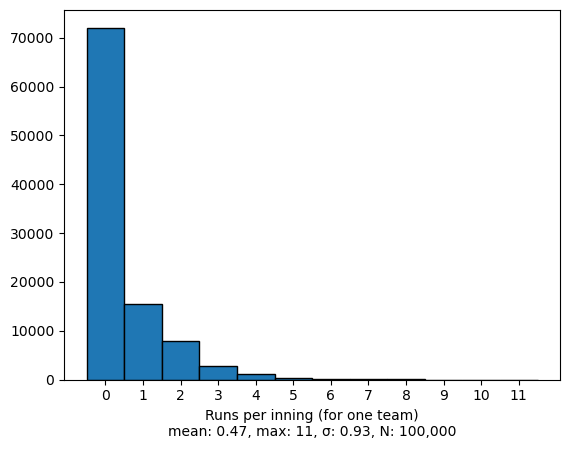

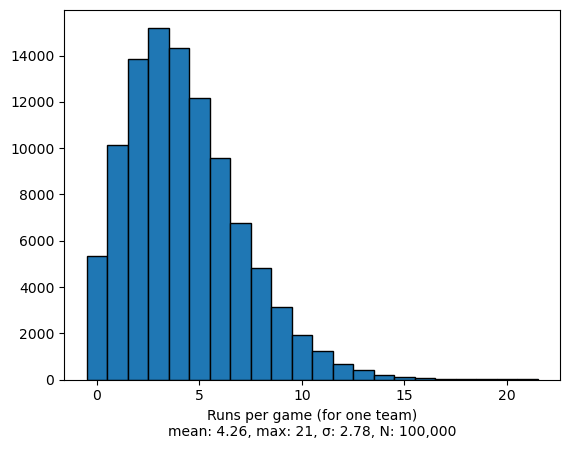

In [22]:
simulate(events=mlb_stream, inning=inning2)

There is a slight increase in the number of runs scored, but we're still a half a run per game below the actual MLB figure. I think that the main reason is that in our simulation, every hitter is average. Real MLB lineups cluster their best hitters together, usually in the 1-4 slot of the lineup, so when one of them gets a hit, another is more likely than average to bat them in. Also, some teams have a higher overall batting average, and thus are more likely to bat their teammates in.

# Opportunities for Improvement

There are many problems with the simulation code as it is. For example:

- It assumes all pitchers and defense are equal. They're not.
- It assumes all batters are equal. They're not. 
- It assumes all hits are the same (runners always advance the same number of bases). They're not.
- There's only one type of double play (batter and runner on first out) and no triple play.
- It ignores stolen bases, pickoffs, passed balls, wild pitches, runners taking extra bases, and runners being out on attempted steals, extra bases, or sacrifices.
- There is no strategy (offense and defense behave the same, regardless of the situation).
- It assumes both teams bat for 9 innings. But if the home team is ahead at the bottom of the 9th, they do not bat, and if the score is tied: extra innings.
- With two outs, or with no runners on base, there can be no sacrifice or double play; those types of events would just be regular outs. The stats say that a double play should occur in 3981 out of 185377 at bats, or about 2% of the time. In our simulation the `D` event code would come up that often, but perhaps only half the time there would be a runner and less than two outs, so we would only actually get a double play maybe 1% of the time.

What can you do to make the simulation better?

# Batting .400 in a Short Season: A Non-Simulation

Here is a different baseball puzzle. The [538 Riddler for 17 July, 2020](https://fivethirtyeight.com/features/can-the-hare-beat-the-tortoise/) asks: what is the likelihood of a baseball player batting .400 in a pandemic-shortened 60 game season? How does that compare to a full (162 game) season? Note that no player  has batted .400 since Ted Williams in 1941.) Assume a player has a probability of .350 of getting a hit in each at bat, independent of any other at bat, and that a player gets exactly 4 at bats in each game.

We could simulate this easily enough. But it is easy, more accurate, and less computation to compute the exact answer. To bat .400 with 4 at bats in each of 60 games, you need to get at least .400 × 4 × 60 = 96 hits in 240 at bats. What's the probability of getting at least *k* hits in *n* at bats, given that the probability of getting a hit in each at bat is *p*? There are three cases:
- If *k* > *n* it is impossible.
- If *k* ≤ 0 it is certain.
- Otherwise: 
  - With probability *p* you get a hit, and then need at least *k* - 1 hits out of *n* - 1 at bats.
  - With probability (1 - *p*) you are out and then need at least *k* hits out of *n* - 1 at bats.
  
We can code that directly:

In [23]:
import functools

@functools.lru_cache(None)
def at_least(k, n, p):
    """The probability of getting at least k out of n hits, when each hit has probability p."""
    return (0.0       if k > n else
            1.0       if k <= 0 else
            p         * at_least(k - 1, n - 1, p)
            + (1 - p) * at_least(k,     n - 1, p))

In [24]:
n1 = 60 * 4 # total number of at bats in a short season

at_least(.400 * n1, n1, 0.350)

0.06083862769698295

In [25]:
n2 = 162 * 4 # total number of at bats in a full season

at_least(.400 * n2, n2, 0.350)

0.003789921663584505

We see that a .350 hitter has a 6% chance of  batting .400 in a short season, but less than a 0.4% chance in a full season. 

Here are some batting leaders from years past, chosen to span the range from .330 to .420; I'll make a table of their chances to hit .400 in both a 60 game and 162 game season:

In [26]:
players = dict(Cabrera=330, Holliday=340, Betts=346, Suzuki=350,
    Bonds=362, Nomar=372, DiMaggio=381, Brett=390, Hornsby=401, 
    Williams=406, Cobb=419)

print('Name       BA  60G     162G')
for name in players:
    pct1 = at_least(.400 * n1, n1, players[name] / 1000)
    pct2 = at_least(.400 * n2, n2, players[name] / 1000)
    print(f'{name:8} .{players[name]:3}  {pct1:3.0%}   {pct2:6.2%}')

Name       BA  60G     162G
Cabrera  .330   1%    0.01%
Holliday .340   3%    0.07%
Betts    .346   5%    0.19%
Suzuki   .350   6%    0.38%
Bonds    .362  12%    2.14%
Nomar    .372  20%    6.75%
DiMaggio .381  29%   15.38%
Brett    .390  40%   29.18%
Hornsby  .401  54%   51.01%
Williams .406  60%   61.21%
Cobb     .419  75%   83.05%
